# Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib 
import pickle

import tensorflow as tf
from keras.layers import *
from keras.regularizers import *
from keras.optimizers import *
from keras.models import *
from keras.preprocessing.text import *
from keras.callbacks import EarlyStopping
import keras.backend as K 
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image

import random
import os
random.seed(42)

/Users/baeyuna/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
new_df = pd.read_csv(os.path.join("..","..","data",'YN_final_df2.csv'))
new_df.head()

/Users/baeyuna/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,rating,locationId,photonum,createdDate,is_fch,is_local,place.name,userID,average_photonum,average_rating,user_mean_rating,user_reviewcount,lat,lng,land.addr,category,rated_count,category_l
0,4.5,1150710065,0,2020-05-21 20:42:00,1,1,스타벅스 보라매공원R점,432293,0.164557,4.506329,4.5,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1
1,5.0,1150710065,0,2019-06-28 01:11:03,1,1,스타벅스 보라매공원R점,135109,0.164557,4.506329,5.0,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1
2,5.0,1150710065,0,2020-03-12 00:22:00,1,1,스타벅스 보라매공원R점,269138,0.164557,4.506329,5.0,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1
3,5.0,1150710065,0,2020-02-16 17:06:00,1,1,스타벅스 보라매공원R점,246123,0.164557,4.506329,5.0,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1
4,5.0,1150710065,0,2019-03-11 00:08:48,1,1,스타벅스 보라매공원R점,119248,0.164557,4.506329,5.0,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1


## 로컬 / 글로벌 데이터 분리

In [3]:
# 로컬 / 글로벌 데이터 분리
local_df = new_df.loc[new_df['is_local']==1]
global_df = new_df.loc[new_df['is_local']==0]
print('local_df shape:',local_df.shape, 'global_df shape :',global_df.shape)

local_df shape: (381125, 18) global_df shape : (98566, 18)


In [4]:
# 로컬, 글로벌 공통 location id 뽑기
local_id = local_df['locationId'].unique().tolist()
global_id = global_df['locationId'].unique().tolist()

common_ids = []
for i in local_id:
    if i in global_id:
        common_ids.append(i)

common_acm = new_df.loc[new_df['locationId'].isin(common_ids)]
common_acm = common_acm.loc[common_acm['category']=='ACM']
common_acm_ids = common_acm['locationId'].unique().tolist()
# global, local 모두 담은 acm location ids
print(len(common_acm_ids)) 

245


## 필요 함수

In [5]:
def get_data(column, df) :
    
    vocab = {}
    num = 0

    for i in df[column]: 
        if vocab.get(i) != None:
            continue

        vocab[i] = num
        num += 1

    encoded = [vocab[i] for i in df[column]]
    return encoded, num, vocab

In [8]:
def trans_mul(vects):
    z = tf.reshape(vects,(-1,n_factors,1))
    return z 

def concat_shape2D(vects):
    a1,a2,a3,a4,a5,a6,a7,a8,a9,a10 = vects 
    z = tf.concat([a1,a2],axis=2)
    z = tf.concat([z,a3],axis=2)
    z = tf.concat([z,a4],axis=2)
    z = tf.concat([z,a5],axis=2)
    z = tf.concat([z,a6],axis=2)
    z = tf.concat([z,a7],axis=2)
    z = tf.concat([z,a8],axis=2)
    z = tf.concat([z,a9],axis=2)
    z = tf.concat([z,a10],axis=2)
#     z = tf.concat([z,a11],axis=2)
    return z

def sum_layer(vects):
    a1,a2,a3,a4,a5,a6,a7,a8,a9,a10 = vects
    z = tf.add(a1,a2)
    z = tf.add(z,a3) 
    z = tf.add(z,a4)
    z = tf.add(z,a5)
    z = tf.add(z,a6)
    z = tf.add(z,a7)
    z = tf.add(z,a8)
    z = tf.add(z,a9)
    z = tf.add(z,a10)
#     z = tf.add(z,a11)
    return z 

In [209]:
local_df_acm = local_df.loc[local_df['category'] == 'ACM']
local_df_eat = local_df.loc[local_df['category'] == 'EAT']

# 평균평점 이상의 식당만 남김.
local_df_eat = local_df_eat.loc[local_df_eat['average_rating']>=local_df_eat['average_rating'].median()]
local_df = pd.concat([local_df_acm, local_df_eat])

# local이기에 global과 차이를 두기위해 최대한 의미없는 체인 제거 
local_df = local_df.loc[local_df['is_fch']==0]

# 의미없는 추천 식당 제거 
local_df = local_df[~local_df['place.name'].str.contains('써브웨이|던킨도너츠|노브랜드버거|바르다김선생|폴바셋|안동찜닭|속초코다리냉면|할매순대국&양선지해장국|노브랜드버거 남부터미널점|바르다김선생|유가네|24시 중식당 취빈|매머드커피|압구정봉구비어|카페베네|쥬씨|피자스쿨|매머드익스프레스|김밥천국|한국맥도날드|메머드커피|신전떡볶이|어사또|공차|북촌손만두|오징어세상|사월에보리밥|땡스브레드엔커피|피자몰|나주소나주곰탕| 새마을식당|싸다김밥| 교동짬뽕| 토마토김밥| 화화쿵주마라탕| 샐러데이즈| 더차이|뚜레쥬르|스쿨푸드|자연별곡|죠스떡볶이|국대떡볶이| 도쿄스테이크|이디야커피| 코스트코코리아양재점푸드코트| 불고기브라더스|알라딘중고서점카페|배스킨라빈스|할리스커피| 와플대학| 파리바게뜨공덕역사| 파리바게뜨|아웃백|설빙| 봉추찜닭| 하겐다즈|아라마크연세의료원종합관|미아리우동집| 서울대학생회관식당|세계과자할인마트| 이삭토스트| 굽네치킨| 깐부치킨| 굽네치킨| 빈스앤베리즈| 롯데리아|던킨 도너츠|피자헛|미쓰족발|덕수궁')]
print('의미없을만한 식당 제거 후 local데이터 크기:',local_df.shape)

의미없을만한 식당 제거 후 local데이터 크기: (126061, 18)


In [210]:
local_df.to_csv(os.path.join("..","realtime_model",'local_df(wnd)2.csv'), index=False)

In [211]:
encoded_userID, num_userID, vocab_userID = get_data('userID', local_df) 
encoded_users_mean_rating, num_users_mean_rating, vocab_users_mean_rating = get_data('user_mean_rating', local_df) 
encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', local_df) 
encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', local_df) 
encoded_createdDate,  num_createdDate, vocab_createdDate = get_data('createdDate', local_df) 
encoded_photonum,  num_photonum, vocab_photonum = get_data('photonum', local_df) 
encoded_fch,  num_fch, vocab_fch = get_data('is_fch', local_df) 
encoded_category_l,  num_category_l, vocab_category_l = get_data('category_l', local_df) 
encoded_rated_count,  num_rated_count, vocab_rated_count = get_data('rated_count', local_df) 
encoded_average_photonum,  num_average_photonum, vocab_average_photonum = get_data('average_photonum', local_df) 
encoded_average_rating,  num_average_rating, vocab_average_rating = get_data('average_rating', local_df) 


## Input Data

In [212]:
n_factors = 8 
layers = [16,8, 4] 

# Input variables
userID = Input(shape=(1,), dtype='int64', name = 'userID') 
users_mean_rating = Input(shape=(1,), dtype='int64', name = 'users_mean_rating') 
user_reviewcount = Input(shape=(1,), dtype='int64', name = 'user_reviewcount') 
locationId = Input(shape=(1,), dtype='int64', name = 'locationId')
placeType = Input(shape=(1,), dtype='int64', name = 'placeType')
createdDate = Input(shape=(1,), dtype='int64', name = 'createdDate')
photonum = Input(shape=(1,), dtype='int64', name = 'photonum')
fch = Input(shape=(1,), dtype='int64', name = 'fch')
category_l = Input(shape=(1,), dtype='int64', name = 'category_l')
rated_count = Input(shape=(1,), dtype='int64', name = 'rated_count')
average_photonum = Input(shape=(1,), dtype='int64', name = 'average_photonum')
average_rating = Input(shape=(1,), dtype='int64', name = 'average_rating')

In [213]:
FM_userID = Embedding(input_dim = num_userID, output_dim = n_factors, 
                              name = 'FM_userID', input_length=1)(userID)
FM_users_mean_rating = Embedding(input_dim = num_users_mean_rating, output_dim = n_factors,
                              name = 'FM_users_mean_rating', input_length=1)(users_mean_rating)  
FM_user_reviewcount = Embedding(input_dim = num_user_reviewcount, output_dim = n_factors, 
                              name = 'FM_user_reviewcount', input_length=1)(user_reviewcount)
FM_locationId= Embedding(input_dim = num_locationId, output_dim = n_factors,
                              name = 'FM_locationId', input_length=1)(locationId)   
FM_createdDate = Embedding(input_dim = num_createdDate, output_dim = n_factors, 
                              name = 'FM_createdDate', input_length=1)(createdDate)
FM_photonum = Embedding(input_dim = num_photonum, output_dim = n_factors, 
                              name = 'FM_photonum', input_length=1)(photonum)
FM_fch = Embedding(input_dim = num_fch, output_dim = n_factors, 
                              name = 'FM_fch', input_length=1)(fch)
FM_category_l = Embedding(input_dim = num_category_l, output_dim = n_factors, 
                              name = 'FM_category_l', input_length=1)(category_l)
FM_rated_count = Embedding(input_dim = num_rated_count, output_dim = n_factors, 
                              name = 'FM_rated_count', input_length=1)(rated_count)
FM_average_photonum = Embedding(input_dim = num_average_photonum, output_dim = n_factors, 
                              name = 'FM_average_photonum', input_length=1)(average_photonum)
FM_average_rating = Embedding(input_dim = num_average_rating, output_dim = n_factors, 
                              name = 'FM_average_rating', input_length=1)(average_rating)

In [214]:
FM_userID_latent = Flatten()(FM_userID)
FM_userID_latent = Lambda(trans_mul)(FM_userID_latent)

FM_users_mean_rating_latent = Flatten()(FM_users_mean_rating)
FM_users_mean_rating_latent = Lambda(trans_mul)(FM_users_mean_rating_latent)

FM_user_reviewcount_latent = Flatten()(FM_user_reviewcount)
FM_user_reviewcount_latent = Lambda(trans_mul)(FM_user_reviewcount_latent)

FM_locationId_latent = Flatten()(FM_locationId)
FM_locationId_latent = Lambda(trans_mul)(FM_locationId_latent)

FM_createdDate_latent = Flatten()(FM_createdDate)
FM_createdDate_latent = Lambda(trans_mul)(FM_createdDate_latent)

FM_photonum_latent = Flatten()(FM_photonum)
FM_photonum_latent = Lambda(trans_mul)(FM_photonum_latent)

FM_fch_latent = Flatten()(FM_fch)
FM_fch_latent = Lambda(trans_mul)(FM_fch_latent)

FM_category_l_latent = Flatten()(FM_category_l)
FM_category_l_latent = Lambda(trans_mul)(FM_category_l_latent)

FM_rated_count_latent = Flatten()(FM_rated_count)
FM_rated_count_latent = Lambda(trans_mul)(FM_rated_count_latent)

FM_average_photonum_latent = Flatten()(FM_average_photonum)
FM_average_photonum_latent = Lambda(trans_mul)(FM_average_photonum_latent)

FM_average_rating_latent = Flatten()(FM_average_rating)
FM_average_rating_latent = Lambda(trans_mul)(FM_average_rating_latent)


FM_conv1d =Lambda(concat_shape2D)([FM_userID_latent, FM_users_mean_rating_latent,
                             FM_user_reviewcount_latent, FM_locationId_latent,
                             FM_createdDate_latent, FM_photonum_latent,
                                  FM_fch_latent, FM_category_l_latent, FM_rated_count_latent,
                                  FM_average_photonum_latent, FM_average_rating_latent])


MF_part = Conv1D(128,kernel_size=1,activation='relu')(FM_conv1d)
MF_part = Flatten()(MF_part)

In [215]:
mlp_concat = Concatenate()([FM_userID_latent, FM_users_mean_rating_latent,
                             FM_user_reviewcount_latent, FM_locationId_latent,
                             FM_createdDate_latent, FM_photonum_latent,
                                  FM_fch_latent, FM_category_l_latent, FM_rated_count_latent,
                                  FM_average_photonum_latent, FM_average_rating_latent])
mlp_concat = Flatten()(mlp_concat)

mlp_concat1 = Dense(layers[0], activation='relu', name=f"layer{0}")(mlp_concat) 
mlp_concat1 = Dense(layers[1], activation='relu', name=f"layer{1}")(mlp_concat1)
mlp_concat = Concatenate()([mlp_concat,mlp_concat1])
mlp_concat = Dense(layers[2],activation='relu')(mlp_concat)

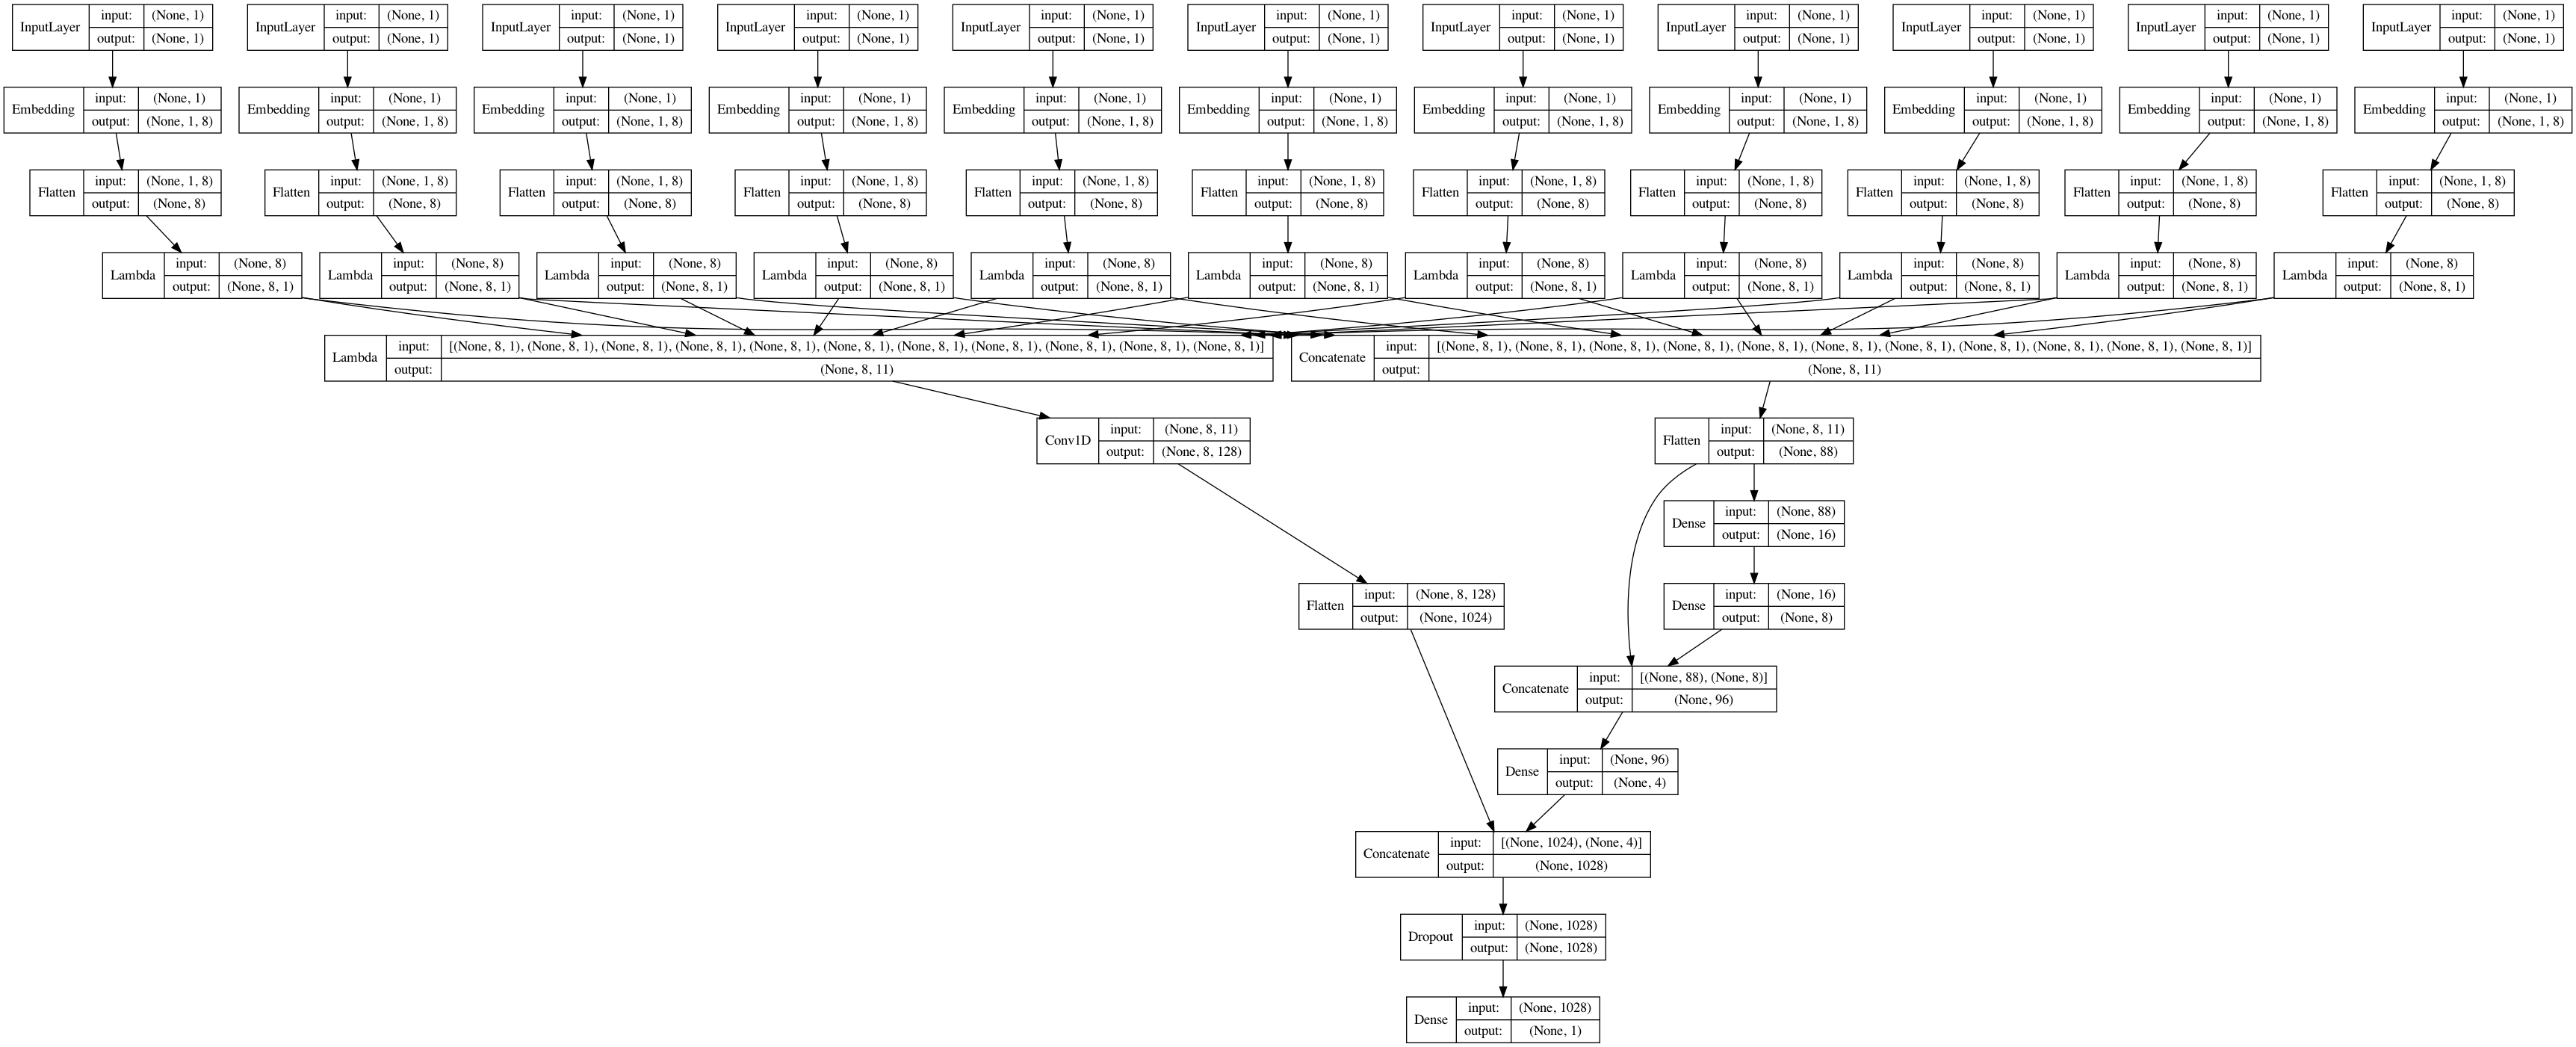

In [216]:
# Concatenate MF and MLP parts
predict_vector = Concatenate()([MF_part, mlp_concat])
predict_vector = Dropout(0.2)(predict_vector)

# Final prediction layer
prediction = Dense(1, name = "prediction")(predict_vector) # activation='sigmoid',
model = Model([userID, users_mean_rating, 
                             user_reviewcount, locationId, 
                             createdDate, photonum, fch, category_l, rated_count,
                                  average_photonum, average_rating], prediction)
model.compile(loss="mse", optimizer=RMSprop(lr=1e-4), metrics=[tf.keras.metrics.AUC()])

Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 125430 samples, validate on 631 samples
Epoch 1/20
125430/125430 [==============================] - 4s 30us/step - loss: 20.3846 - auc_3: 0.0000e+00 - val_loss: 19.6994 - val_auc_3: 0.0000e+00
Epoch 2/20
125430/125430 [==============================] - 3s 28us/step - loss: 19.1075 - auc_3: 0.0000e+00 - val_loss: 18.2206 - val_auc_3: 0.0000e+00
Epoch 3/20
125430/125430 [==============================] - 3s 27us/step - loss: 17.3491 - auc_3: 0.0000e+00 - val_loss: 16.2230 - val_auc_3: 0.0000e+00
Epoch 4/20
125430/125430 [==============================] - 4s 29us/step - loss: 15.0533 - auc_3: 0.0000e+00 - val_loss: 13.7269 - val_auc_3: 0.0000e+00
Epoch 5/20
125430/125430 [==============================] - 4s 29us/step - loss: 12.2840 - auc_3: 0.0000e+00 - val_loss: 10.8358 - val_auc_3: 0.0000e+00
Epoch 6/20
125430/125430 [==============================] - 4s 30us/step - loss: 9.2022 - auc_3: 0.0000e+00 - val_loss: 7.7459 - val_auc_3: 0.0000e+00
Epoch 7/20
125430/125430 [=========

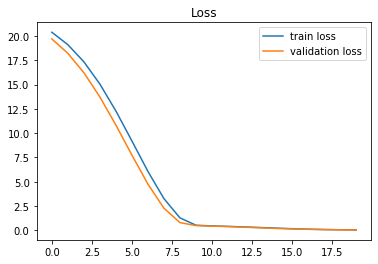

In [217]:
history = model.fit(x=[encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                       encoded_fch, encoded_category_l, encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating],
                    y=local_df['rating'], batch_size=2048, epochs=20, validation_split=0.005, verbose=1)

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend() 
plt.title("Loss")
plt.show()

In [218]:
# # 모델 저장하기 
# model.save_weights(os.path.join("..","realtime_model",'wnd_local_model2.h5'))

# model_json = model.to_json()
# with open(os.path.join("..","realtime_model","wnd_local_model2.json"), "w") as json_file : 
#     json_file.write(model_json)
    
# print("Saved model to disk")

## item 유사도 반환

In [219]:
# # 모델 불러오기 
# from keras.models import model_from_json 
# json_file = open(os.path.join("..","realtime_model","wnd_local_model2.json"), "r") 
# loaded_model_json = json_file.read() 
# json_file.close() 

# loaded_model = model_from_json(loaded_model_json, custom_objects={'tf': tf, 'n_factors':8})

# loaded_model.load_weights(os.path.join("..","realtime_model","wnd_local_model2.h5"))
# print("Loaded model from disk")

In [220]:
def latent_to_vec(feature, model, location_df, h_size, input_features):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    test = input_features
                             
    locationId_latent_vector = intermediate_layer_model.predict(test)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']
    
    # 아이템별 의미 벡터 생성 
    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId')
    return vec

In [221]:
vec = latent_to_vec('FM_locationId', model, local_df, 8, [encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                       encoded_fch, encoded_category_l, encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating])

In [222]:
vec.to_csv(os.path.join("..","realtime_model",'wnd_local_vec2.csv'))#, index=False)

vecs = pd.read_csv(os.path.join("..","realtime_model",'wnd_local_vec2.csv'))
vecs

,locationId,0,1,2,3,4,5,6,7
0,1287253850,-0.020092,-0.020092,-0.019883,-0.016707,-0.016024,-0.016024,-0.017320,-0.017320
1,1135614482,-0.014900,-0.014900,-0.014900,-0.016584,-0.027330,-0.027330,-0.027330,-0.027330
2,18552459,-0.006335,-0.006335,-0.006335,-0.006335,-0.006335,-0.006335,-0.006335,-0.006335
3,1500428988,-0.020990,-0.020990,-0.024645,-0.027616,-0.023373,-0.023373,-0.023373,-0.023373
4,12309433,-0.012898,-0.012898,-0.012898,-0.016047,-0.015929,-0.013389,-0.012452,-0.012452
...,...,...,...,...,...,...,...,...,...
4670,8932954,-0.039596,-0.039596,-0.039596,-0.039596,-0.039596,-0.044684,-0.044684,-0.034770
4671,4171321,-0.050513,-0.052680,-0.052680,-0.049200,-0.049200,-0.051422,-0.051422,-0.051422
4672,4826338,-0.042642,-0.042642,-0.042642,-0.042642,-0.042642,-0.035939,-0.035939,-0.042354
4673,4033778,-0.031149,-0.031149,-0.031149,-0.034033,-0.033901,-0.033901,-0.040215,-0.040215


In [223]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
import random

def cosim_id(df, vec, item_id):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy() 
    sim = []
    
    # 인풋 호텔 정보 데이터에 없는 경우 종료 
    if item_id not in vec.index.tolist():
        return 
        
    for i in range(len(vec)):
        sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))

    new_vec['sim'] = sim
    # sim 높은 순 
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    sim_sorted = new_vec['locationId'].tolist()
    # 인풋 호텔정보 빼고 유사도 높은 순대로 id 
    if item_id in sim_sorted:
        sim_sorted.remove(item_id) 
    return sim_sorted 


def sim_item(vec, df, item_id, top):
    top_id = cosim_id(df, vec, item_id)
    
    if type(top_id) == list :
        df = df.drop_duplicates(['locationId'], keep='last')
        recommend_rst = []
        for x in top_id:
            if df.loc[df['locationId']==x].category.values[0]== 'EAT':
                recommend_rst.append([df.loc[df['locationId']==x][['place.name', 'land.addr']]])

        print('input hotel:', local_df.loc[local_df['locationId']==item_id]['place.name'].unique()[0])
        print('-'*10)
        for i in range(len(recommend_rst[:top])):
            print('top', i+1, recommend_rst[i][0]['place.name'].values[0])
            print('  주소', recommend_rst[i][0]['land.addr'].values[0])
        
    else:
        answer_lst = ['해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.', '해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.']
        x = random.randint(0, len(answer_lst)-1)
        return answer_lst[x]
    

In [224]:
import random

for location_id in common_acm_ids[:10]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔에잇아워즈
----------
top 1 일도씨곱창
  주소 서울특별시 강남구 신사동 561-9
top 2 탐앤탐스
  주소 서울특별시 서대문구 창천동 33-4
top 3 진성한우곱창
  주소 서울특별시 강동구 천호동 415-5
top 4 역전소금구이
  주소 서울특별시 영등포구 영등포동3가 10-41
top 5 산채향
  주소 서울특별시 중구 무교동 96
top 6 규자카야 모토
  주소 서울특별시 마포구 연남동 224-26
top 7 뱅뱅막국수
  주소 서울특별시 강남구 도곡동 943-2 서한빌딩
top 8 가연
  주소 서울특별시 강남구 역삼동 736-56 스타빌딩
top 9 미소샤브칼국수
  주소 서울특별시 성북구 동선동1가 4-1
top 10 오늘은즉떡 본점
  주소 서울특별시 영등포구 여의도동 25-3 동화빌딩
None



--------------------------------------------------
input hotel: 노보텔스위트앰배서더서울용산
----------
top 1 때때로 고기
  주소 서울특별시 종로구 관철동 25 모암회관
top 2 라콜롬브
  주소 서울특별시 종로구 동숭동 1-181 대학로 아트원씨어터
top 3 서울족발
  주소 서울특별시 성북구 길음동 1284 길음뉴타운
top 4 톰스피자
  주소 서울특별시 종로구 평창동 325
top 5 라고파스타
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 6 FAVORITE COFFEE
  주소 서울특별시 서대문구 창천동 18-20
top 7 그랑아
  주소 서울특별시 금천구 독산동 1030-1 노보텔앰배서더
top 8 서울뚝배기
  주소 서울특별시 중구 충무로3가 24-14
top 9 빨간오뎅 부산어묵
  주소 서울특별시 강남구 개포동 186-5
top 10 이월로스터스 송파점
  주소 서울특별시 송파구 송파동 51-7
None



--------------------------------------------------
i

In [225]:
import random

for location_id in common_acm_ids[10:20]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 롯데시티호텔 마포
----------
top 1 비야부대찌개본점
  주소 서울특별시 성북구 안암동5가 15-16
top 2 만점족
  주소 서울특별시 중구 태평로2가 330-2
top 3 체부동잔치집
  주소 서울특별시 종로구 체부동 190
top 4 오프셋커피
  주소 서울특별시 중구 신당동 340-83
top 5 매덕스피자
  주소 서울특별시 용산구 이태원동 129-9
top 6 방이편백 육분삼십 성신여대점
  주소 서울특별시 성북구 동선동1가 4-9
top 7 아르테미스
  주소 서울특별시 성북구 하월곡동 46-73 코업스타클래스
top 8 코야코
  주소 서울특별시 종로구 동숭동 128-5 호은빌딩
top 9 정돈 대학로본점
  주소 서울특별시 종로구 명륜4가 107
top 10 헤비스테이크 종로구청점
  주소 서울특별시 종로구 청진동 216-1
None



--------------------------------------------------
input hotel: 레스케이프 호텔
----------
top 1 복성각
  주소 서울특별시 서대문구 충정로2가 2-2 충정빌딩
top 2 맛동 가나다밥상
  주소 서울특별시 은평구 녹번동 7 서울혁신파크
top 3 강남곱
  주소 서울특별시 강남구 역삼동 830-31
top 4 최월선원조등촌칼국수
  주소 서울특별시 서초구 서초동 1696-13 애니빌딩
top 5 미시락칼국수
  주소 서울특별시 양천구 목2동 527-9
top 6 포멜로빈 공덕점
  주소 서울특별시 마포구 공덕동 478 공덕더샵아파트
top 7 그라인드커피
  주소 서울특별시 금천구 가산동 371-28 우림라이온스밸리
top 8 쿠차라 종로점
  주소 서울특별시 종로구 청진동 70 그랑서울
top 9 쥬빌리김밥
  주소 서울특별시 영등포구 당산동5가 11-34 삼성타운
top 10 달콤커피
  주소 서울특별시 마포구 상암동 1592 팬엔터테인먼트 사옥
None



--------------------------

In [226]:
import random

for location_id in common_acm_ids[20:30]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 강남아르누보시티
----------
top 1 돈부리 명동점
  주소 서울특별시 중구 저동1가 103-9
top 2 송 현대백화점무역센터점
  주소 서울특별시 강남구 삼성동 159-7 현대백화점
top 3 다마식당
  주소 서울특별시 노원구 상계동 594-2 보광빌딩
top 4 소르빌로1991
  주소 서울특별시 성북구 동선동1가 92-3
top 5 흑백집 구로디지털점
  주소 서울특별시 구로구 구로동 212-8 대륭포스트타워1차
top 6 죽향 롯데백화점 관악점
  주소 서울특별시 관악구 봉천동 729-22 롯데백화점
top 7 코야코
  주소 서울특별시 종로구 동숭동 128-5 호은빌딩
top 8 롸카두들 내쉬빌 핫치킨
  주소 서울특별시 용산구 이태원동 449-1
top 9 플로리다반점
  주소 서울특별시 마포구 합정동 391-19
top 10 해룡마라룽샤
  주소 서울특별시 중구 을지로6가 18-66 임성빌딩
None



--------------------------------------------------
input hotel: TheK호텔 서울
----------
top 1 카즈야
  주소 서울특별시 강남구 역삼동 678-24 늘봄빌딩
top 2 천호낙지
  주소 서울특별시 동대문구 장안동 107-8 삼협메디스빌딩
top 3 고양이부엌
  주소 서울특별시 서초구 서초동 1317-3
top 4 굿모닝
  주소 서울특별시 종로구 인의동 112-2 세운스퀘어
top 5 고릴라
  주소 서울특별시 서대문구 충정로3가 272
top 6 타이러브
  주소 서울특별시 성동구 성수동2가 315-54 해피드림
top 7 브라운시티
  주소 서울특별시 마포구 합정동 412-4
top 8 초림정
  주소 서울특별시 성북구 돈암동 48-4 성북성심빌딩
top 9 오투베이커리
  주소 서울특별시 마포구 대흥동 322-2
top 10 스시옥
  주소 서울특별시 금천구 독산동 291-6 시티렉스
None



---------------------

In [227]:
import random

for location_id in common_acm_ids[30:40]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 스타즈호텔 명동1호점
----------
top 1 BLT 스테이크
  주소 서울특별시 종로구 종로6가 289-3
top 2 베로나
  주소 서울특별시 중구 을지로3가 320-24
top 3 마포갈비
  주소 서울특별시 동작구 대방동 406-6 마포갈비
top 4 망우로30
  주소 서울특별시 동대문구 휘경동 317-60
top 5 서울브루어리
  주소 서울특별시 마포구 합정동 368-10
top 6 캘리포니아피자키친 용산아이파크몰점
  주소 서울특별시 용산구 한강로3가 40-999 용산역
top 7 노스쇼어
  주소 서울특별시 마포구 서교동 395-124
top 8 시민식당
  주소 서울특별시 종로구 낙원동 192
top 9 그린버킷
  주소 서울특별시 영등포구 여의도동 32-1
top 10 정식당
  주소 서울특별시 강남구 청담동 83-24
None



--------------------------------------------------
input hotel: 글래드 여의도
----------
top 1 화담
  주소 서울특별시 송파구 잠실동 177-4
top 2 브런치팩토리
  주소 서울특별시 강서구 마곡동 751 마곡엠밸리15단지
top 3 해품초삼성
  주소 서울특별시 강남구 삼성동 154-11 M타워
top 4 다다익선
  주소 서울특별시 종로구 익선동 123-2
top 5 정신
  주소 서울특별시 중구 북창동 77-2
top 6 국고집 대치점
  주소 서울특별시 강남구 대치동 896-16
top 7 론드리프로젝트
  주소 서울특별시 용산구 용산동2가 15-13
top 8 쉐라톤그랜드워커힐 더뷔페
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 9 완차이면가
  주소 서울특별시 종로구 종로1가 24 르메이에르종로타운1
top 10 카페 아르무아
  주소 서울특별시 광진구 화양동 5-32
None



--------------------------------------------------
input hot

In [228]:
import random

for location_id in common_acm_ids[40:50]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 골든서울호텔
----------
top 1 송이네
  주소 서울특별시 마포구 망원동 414-6
top 2 을지수제비
  주소 서울특별시 중구 을지로3가 291-39
top 3 바다해물포차
  주소 서울특별시 서초구 방배동 951-31
top 4 꽁시면관
  주소 서울특별시 종로구 관철동 246-2
top 5 옛집국수
  주소 서울특별시 용산구 한강로1가 231-23
top 6 마마쿡
  주소 서울특별시 금천구 독산동 1155 금천롯데캐슬골드파크3차
top 7 우야꼬칼국수파전
  주소 서울특별시 성동구 성수동2가 289-69
top 8 대보명가
  주소 서울특별시 강북구 수유동 563-14
top 9 아시안 라이브
  주소 error
top 10 옷살
  주소 서울특별시 관악구 봉천동 856-5 대우디오슈페리움1단지
None



--------------------------------------------------
input hotel: 나인트리프리미어호텔 명동2
----------
top 1 깔리
  주소 서울특별시 종로구 명륜4가 171
top 2 댈러스바베큐
  주소 서울특별시 강남구 신사동 544-5
top 3 노블베이커리
  주소 서울특별시 서대문구 남가좌동 338-1
top 4 도미노피자
  주소 서울특별시 서초구 잠원동 15-9 태승빌딩
top 5 북해빙수 수표점
  주소 서울특별시 중구 수표동 11-8
top 6 모래내설농탕본점
  주소 서울특별시 서대문구 홍은동 415-46
top 7 바른고기 정육점 을지로점
  주소 서울특별시 중구 수표동 99 시그니쳐타워
top 8 블랑제리11-17
  주소 서울특별시 강동구 성내동 78-1 강동메디컬센터
top 9 마라E민족 역삼본점
  주소 서울특별시 강남구 역삼동 828-25
top 10 멜로우
  주소 서울특별시 마포구 서교동 368-7
None



--------------------------------------------------
input hotel: 노보텔 앰

In [229]:
import random

for location_id in common_acm_ids[50:60]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 라마다호텔앤스위트서울남대문
----------
top 1 연세대학교신촌캠펴스 웰스토리
  주소 서울특별시 서대문구 신촌동 134 신촌세브란스병원
top 2 카페 붘
  주소 서울특별시 용산구 이촌동 302-146
top 3 빵이가
  주소 서울특별시 노원구 상계동 1132-35
top 4 어바웃진스 바베큐 키친
  주소 서울특별시 종로구 내수동 167 대우빌딩
top 5 용삼계탕
  주소 서울특별시 강남구 논현동 141-17
top 6 림벅와플
  주소 서울특별시 중구 태평로2가 365
top 7 11번가식당
  주소 서울특별시 성동구 성수동2가 328-6
top 8 호치킨 길음뉴타운점
  주소 서울특별시 성북구 길음동 1282-3
top 9 우리네코다리대치점
  주소 서울특별시 강남구 대치동 629 동하빌딩
top 10 빌리엔젤케익컴퍼니
  주소 서울특별시 종로구 팔판동 5-3
None



--------------------------------------------------
input hotel: 베스트웨스턴프리미어서울가든호텔
----------
top 1 한동길뼈다귀감자탕 신내본점
  주소 서울특별시 중랑구 신내동 648 디아뜨갤러리
top 2 연어초밥
  주소 서울특별시 서대문구 대현동 104-40
top 3 공주떡집 롯데백화점잠실점
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 4 오향가
  주소 서울특별시 송파구 가락동 73-2
top 5 달식당
  주소 서울특별시 종로구 관훈동 198-8 종로빌딩
top 6 쿠아레비
  주소 서울특별시 은평구 역촌동 17-15
top 7 골드피쉬 딤섬퀴진
  주소 서울특별시 강남구 신사동 657-5
top 8 언덕위에 국수가게
  주소 서울특별시 용산구 이태원동 20-6
top 9 MouseRabbit
  주소 서울특별시 광진구 화양동 5-14
top 10 정성한줄
  주소 서울특별시 강남구 대치동 1021-10
None



--------------------------

In [230]:
import random

for location_id in common_acm_ids[60:70]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 강남패밀리호텔
----------
top 1 길초밥
  주소 서울특별시 관악구 신림동 1640-38 양지순대촌
top 2 카페드커넥트
  주소 서울특별시 강남구 신사동 627
top 3 심연한우
  주소 서울특별시 강남구 논현동 122-8 동화상가
top 4 달맞이
  주소 서울특별시 강남구 논현동 144
top 5 화룽마라룽샤 - 명동
  주소 서울특별시 중구 을지로2가 199-74
top 6 비파티세리
  주소 서울특별시 강남구 신사동 546-17 인자빌딩
top 7 하프커피 안국점
  주소 서울특별시 종로구 계동 131-2
top 8 치맛살
  주소 서울특별시 중구 신당동 381-15
top 9 기러기둥지
  주소 서울특별시 종로구 돈의동 33
top 10 오다리집
  주소 서울특별시 중구 충무로1가 22-17
None



--------------------------------------------------
input hotel: 아트리움바비엥2
----------
top 1 그림나베
  주소 서울특별시 서초구 방배동 837-12 중전빌딩
top 2 한상가득왕솥뚜껑
  주소 서울특별시 마포구 상암동 1484
top 3 황산샤브샤브
  주소 서울특별시 종로구 수송동 58 두산위브파빌리온
top 4 카페유노
  주소 서울특별시 도봉구 방학동 718-7 이에스에이아파트
top 5 시래불고기 화풍정
  주소 서울특별시 동작구 상도동 324-1 성대시장
top 6 레드175 대치역점
  주소 서울특별시 강남구 대치동 507-1 풍림프라자
top 7 레스토랑 오늘
  주소 서울특별시 용산구 동빙고동 1-102 행복나눔재단
top 8 광어2마리 보라매점
  주소 서울특별시 관악구 신림동 1445-16
top 9 다운타우너 잠실점
  주소 서울특별시 송파구 송파동 46-4
top 10 선진국낙지마당
  주소 서울특별시 동대문구 장안동 306-11
None



--------------------------------------------

In [231]:
import random

for location_id in common_acm_ids[70:80]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 인터시티365
----------
top 1 스시 효
  주소 서울특별시 강남구 청담동 21-16 유현빌딩
top 2 비사벌전주콩나물국밥 성내점
  주소 서울특별시 강동구 성내동 552-4 청정빌딩
top 3 직화뚝배기
  주소 서울특별시 강남구 논현동 114-25
top 4 크래프트밈
  주소 서울특별시 종로구 명륜4가 142
top 5 우부래도
  주소 서울특별시 동작구 상도1동 666-3 수빈명가
top 6 임꺽정부대찌개
  주소 서울특별시 양천구 목동 405-178
top 7 마담밍
  주소 서울특별시 강남구 대치동 889-65
top 8 브로트아트
  주소 서울특별시 영등포구 여의도동 32-1
top 9 광화문 미진 신세계백화점 영등포점
  주소 서울특별시 영등포구 영등포동4가 434-5 신세계백화점
top 10 도수향
  주소 서울특별시 강남구 신사동 662-7
None



--------------------------------------------------
input hotel: Hotel in 9
----------
top 1 맘스터치 낙성대역점
  주소 서울특별시 관악구 봉천동 1688-124
top 2 도마
  주소 서울특별시 종로구 관훈동 15-1
top 3 더담다
  주소 서울특별시 서대문구 대현동 60-11
top 4 마뇨떡볶이
  주소 서울특별시 관악구 신림동 1638-1 삼모더프라임타워
top 5 메이비카페
  주소 서울특별시 구로구 구로동 1124-49
top 6 파리크라상
  주소 서울특별시 용산구 동자동 43-205 한국철도공사
top 7 연탄불꼼장어
  주소 서울특별시 성동구 성수동1가 656-287
top 8 진주집
  주소 서울특별시 영등포구 여의도동 36-2
top 9 브레드05
  주소 서울특별시 영등포구 여의도동 41-1
top 10 이디야 가든파이브점
  주소 서울특별시 송파구 문정동 628 가든파이브툴
None



--------------------------------------

In [232]:
import random

for location_id in common_acm_ids[80:90]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: G2 호텔
----------
top 1 서관면옥
  주소 서울특별시 서초구 서초동 1675-5
top 2 죠티인도레스토랑
  주소 서울특별시 중구 충무로5가 85-2 고려빌딩
top 3 원조보리밥
  주소 서울특별시 용산구 이태원동 34-103
top 4 두가헌
  주소 서울특별시 종로구 사간동 109-1
top 5 카페다락
  주소 서울특별시 중구 서소문동 37 서울시청 서소문별관
top 6 태화루
  주소 서울특별시 동대문구 장안동 403-3
top 7 홍콩반점0410
  주소 서울특별시 종로구 명륜2가 184
top 8 만복기사식당불백전골
  주소 서울특별시 마포구 망원동 455-1
top 9 미와쿠
  주소 서울특별시 용산구 남영동 72-1
top 10 락희옥 을지로점
  주소 서울특별시 중구 을지로2가 101-11
None



--------------------------------------------------
input hotel: 서울 렉스 호텔
----------
top 1 올드페리도넛
  주소 서울특별시 용산구 한남동 727-21
top 2 강남면옥
  주소 서울특별시 성동구 성수동1가 13-164 서울숲 IT 밸리
top 3 개뿔
  주소 서울특별시 종로구 이화동 9-443
top 4 패밀리만두 염창본점
  주소 서울특별시 강서구 염창동 282-20 동원빌딩
top 5 BNHR
  주소 서울특별시 용산구 한남동 683-36
top 6 동차밥
  주소 서울특별시 마포구 연남동 390-78
top 7 간판없는 김치찌개집
  주소 서울특별시 종로구 경운동 66-2
top 8 삼대나주곰탕
  주소 서울특별시 중구 을지로2가 199-53
top 9 시카노이에
  주소 서울특별시 종로구 신문로2가 1-104 신문로하우스
top 10 올드문래
  주소 서울특별시 영등포구 문래동2가 14-28
None



--------------------------------------------------
input hotel: 라까

In [233]:
import random

for location_id in common_acm_ids[90:100]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 롯데 호텔 서울
----------
top 1 타이러브
  주소 서울특별시 성동구 성수동2가 315-54 해피드림
top 2 스시옥
  주소 서울특별시 금천구 독산동 291-6 시티렉스
top 3 24시뼈다귀감자탕
  주소 서울특별시 용산구 한남동 634-1
top 4 또보겠지떡볶이집호호피크닉점
  주소 서울특별시 마포구 서교동 396-45
top 5 훅트포케
  주소 error
top 6 박가네뼈다귀감자탕 본점
  주소 서울특별시 중랑구 중화동 209-2
top 7 마포곱창타운
  주소 서울특별시 마포구 동교동 197-5
top 8 땅코참숯구이
  주소 서울특별시 성동구 행당동 298-55
top 9 고양이부엌
  주소 서울특별시 서초구 서초동 1317-3
top 10 코너스톤
  주소 서울특별시 강남구 대치동 995-14 호텔아이파크(주)
None



--------------------------------------------------
input hotel: 이비스 스타일 앰배서더 서울 명동
----------
top 1 열정도 감자집
  주소 서울특별시 용산구 원효로1가 44-22
top 2 달콤한거짓말
  주소 서울특별시 마포구 상수동 317-11
top 3 몰타참치
  주소 서울특별시 강남구 대치동 891-48 돌채타워
top 4 진성한우곱창
  주소 서울특별시 송파구 가락동 80 송파성원쌍떼빌
top 5 무한야끼
  주소 서울특별시 강서구 마곡동 774-9 사이언스타
top 6 만나식당
  주소 서울특별시 마포구 성산동 260-14
top 7 도레도레
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 8 서래마을이야기
  주소 서울특별시 서초구 반포동 549-11
top 9 피어커피 광희문
  주소 서울특별시 중구 신당동 393-11
top 10 노아베이커리 압구정점
  주소 서울특별시 강남구 신사동 612
None



-------------------------------------------

In [234]:
import random

for location_id in common_acm_ids[100:110]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 포시즌스 호텔 서울
----------
top 1 한상가득왕솥뚜껑
  주소 서울특별시 마포구 상암동 1484
top 2 그림나베
  주소 서울특별시 서초구 방배동 837-12 중전빌딩
top 3 시래불고기 화풍정
  주소 서울특별시 동작구 상도동 324-1 성대시장
top 4 카페유노
  주소 서울특별시 도봉구 방학동 718-7 이에스에이아파트
top 5 황산샤브샤브
  주소 서울특별시 종로구 수송동 58 두산위브파빌리온
top 6 다운타우너 잠실점
  주소 서울특별시 송파구 송파동 46-4
top 7 레드175 대치역점
  주소 서울특별시 강남구 대치동 507-1 풍림프라자
top 8 선진국낙지마당
  주소 서울특별시 동대문구 장안동 306-11
top 9 커피볶는이야기두번째공간
  주소 서울특별시 성북구 동소문동1가 32-2
top 10 레스토랑 오늘
  주소 서울특별시 용산구 동빙고동 1-102 행복나눔재단
None



--------------------------------------------------
input hotel: 호텔28 명동
----------
top 1 카사 코로나 서울
  주소 서울특별시 용산구 이태원동 127-15
top 2 카우카우키친 롯데백화점잠실점
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 3 페이브베이커리 방배본점
  주소 서울특별시 서초구 방배동 850-34 엠아이 빌딩
top 4 진동횟집
  주소 서울특별시 중구 북창동 63
top 5 얼터너티브
  주소 서울특별시 송파구 송파동 131-25 신화빌딩
top 6 활짝핀메밀
  주소 서울특별시 종로구 통의동 109
top 7 세컨드클락
  주소 서울특별시 서초구 신원동 263-6
top 8 우와
  주소 서울특별시 마포구 서교동 364-10
top 9 폴앤폴리나 여의도점
  주소 서울특별시 영등포구 여의도동 37 아일렉스
top 10 오뎅식당 롯데월드몰점
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
None



In [235]:
import random

for location_id in common_acm_ids[110:120]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 스카이파크 센트럴 명동
----------
top 1 만나식당
  주소 서울특별시 마포구 성산동 260-14
top 2 달콤한거짓말
  주소 서울특별시 마포구 상수동 317-11
top 3 반상회
  주소 서울특별시 강동구 성내동 438-4 조아트
top 4 김재운 초밥사랑
  주소 서울특별시 마포구 공덕동 478 공덕더샵아파트
top 5 몰타참치
  주소 서울특별시 강남구 대치동 891-48 돌채타워
top 6 Huggers
  주소 error
top 7 나무와 벽돌
  주소 서울특별시 종로구 신문로1가 6
top 8 88선수촌 잠실새내점
  주소 서울특별시 송파구 잠실동 185-12
top 9 낭만치맥
  주소 서울특별시 강서구 등촌동 78-7 길훈엔트런스빌
top 10 이샘컵케이크
  주소 서울특별시 서초구 반포동 537-4
None



--------------------------------------------------
input hotel: 이코노미 호텔 명동 프리미어
----------
top 1 순댕이네얼큰수제비
  주소 서울특별시 금천구 독산동 160-17
top 2 스템커피
  주소 서울특별시 강남구 삼성동 159 코엑스인터콘티넨탈서울
top 3 정성식당
  주소 서울특별시 구로구 신도림동 337 신도림1차푸르지오
top 4 동굴과화로구이
  주소 서울특별시 은평구 녹번동 185
top 5 밍글스
  주소 error
top 6 수미관
  주소 서울특별시 서초구 서초동 1427-5 청산빌딩
top 7 로향양꼬치 1호점
  주소 서울특별시 관악구 봉천동 1601-10 푸르빌아파트
top 8 이치젠
  주소 서울특별시 마포구 망원동 415-31 연진빌딩
top 9 춘천집닭갈비
  주소 서울특별시 관악구 신림동 1640-28
top 10 젤라띠젤라띠
  주소 서울특별시 마포구 동교동 190-1
None



--------------------------------------------------
input hote

In [236]:
import random

for location_id in common_acm_ids[120:130]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 을지로 코업레지던스
----------
top 1 희래식당
  주소 서울특별시 서대문구 창천동 13-28
top 2 굿모닝
  주소 서울특별시 종로구 관철동 7-12 동일빌딩
top 3 허브족발
  주소 서울특별시 영등포구 당산동6가 302
top 4 단지커피
  주소 서울특별시 광진구 군자동 150-10
top 5 이태리재
  주소 서울특별시 종로구 소격동 158-1
top 6 연남테라스
  주소 서울특별시 마포구 연남동 228-7
top 7 구름산원주추어탕
  주소 서울특별시 구로구 구로동 197-17 에이스테크노타워1차
top 8 크리스마스빈 경찰병원
  주소 서울특별시 송파구 가락동 78 아이티벤처타워
top 9 커피빈
  주소 서울특별시 중구 명동1가 1-3 YWCA연합회
top 10 참숯골
  주소 서울특별시 중구 무교동 19 체육회관
None



--------------------------------------------------
input hotel: 사보이호텔
----------
top 1 공릉닭한마리
  주소 서울특별시 서대문구 대현동 104-69 부소빌딩
top 2 더베이크 센터마크호텔점
  주소 서울특별시 종로구 관훈동 198-42 관훈빌딩(센터마크호텔)
top 3 다락
  주소 서울특별시 마포구 도화동 340 에어몰 빌딩
top 4 혜화칼국수
  주소 서울특별시 종로구 혜화동 84-3
top 5 고기꾼김춘배
  주소 서울특별시 마포구 서교동 369-44
top 6 연세대학교생협 솟을샘
  주소 서울특별시 서대문구 신촌동 134 신촌세브란스병원
top 7 정돈 대학로본점
  주소 서울특별시 종로구 명륜4가 107
top 8 MAILLET
  주소 서울특별시 서초구 반포동 106-5 토마소닉스빌딩
top 9 후라토식당 상수직영점
  주소 서울특별시 마포구 상수동 313-2
top 10 숯불탁탁 마장점
  주소 서울특별시 성동구 마장동 510-8
None



-----------------------------

In [237]:
import random

for location_id in common_acm_ids[130:140]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 트레블로지 명동 을지로호텔
----------
top 1 방배 김밥
  주소 서울특별시 동작구 사당동 127-27 동성빌딩
top 2 김작가의이중생활
  주소 서울특별시 강남구 청담동 120-5
top 3 순금이떡볶이
  주소 서울특별시 광진구 구의동 53-14
top 4 안동반점
  주소 서울특별시 성북구 보문동1가 107
top 5 이북집찹쌀순대
  주소 서울특별시 중구 신당동 100-6
top 6 다채
  주소 서울특별시 강남구 청담동 92-2
top 7 마싯내
  주소 서울특별시 송파구 석촌동 157-4 수정빌딩
top 8 IL Coffee
  주소 서울특별시 관악구 봉천동 1568-1
top 9 우야꼬칼국수파전
  주소 서울특별시 성동구 성수동2가 289-69
top 10 송쉐프
  주소 서울특별시 동대문구 장안동 464-5
None



--------------------------------------------------
input hotel: 호텔 스카이파크 명동 1
----------
top 1 옛날그맛명동칼국수
  주소 서울특별시 금천구 가산동 371-17 BYC HIGHCITY
top 2 허수아비경희대점
  주소 서울특별시 동대문구 회기동 39-3
top 3 대학로에 취하다
  주소 서울특별시 종로구 동숭동 1-37 로얄케스트
top 4 달인겉절이칼국수보쌈
  주소 서울특별시 중구 저동1가 104 파인에비뉴
top 5 황인상브레드
  주소 서울특별시 마포구 신공덕동 167 메트로디오빌빌딩
top 6 클라르테
  주소 서울특별시 마포구 연남동 383-103
top 7 알찬밥집 3호점
  주소 서울특별시 마포구 서교동 341-1 마포평생학습관
top 8 어썸로즈
  주소 서울특별시 강남구 신사동 520-7
top 9 프리퍼
  주소 서울특별시 서초구 서초동 1475-5 성원빌딩
top 10 화양시장할머니순대국
  주소 서울특별시 광진구 자양동 226-24 선진빌딩
None



----------------------

In [238]:
import random

for location_id in common_acm_ids[140:150]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 통 서울 명동
----------
top 1 해바라기정육식당화곡점
  주소 서울특별시 강서구 화곡동 342-49
top 2 김밥처럼선유도역점
  주소 서울특별시 영등포구 양평동5가 67
top 3 빵이가득한집
  주소 서울특별시 양천구 목동 610-23 자성빌딩
top 4 서울안심축산 신도림점
  주소 서울특별시 구로구 신도림동 337 신도림1차푸르지오
top 5 푸주옥
  주소 서울특별시 양천구 신정동 1290-2
top 6 동남집
  주소 서울특별시 구로구 구로동 222-3 제이앤케이디지털타워
top 7 포가레
  주소 서울특별시 마포구 연남동 373-13
top 8 수정옥돌생소금구이
  주소 서울특별시 마포구 서교동 331-1
top 9 동대문닭한마리칼국수
  주소 서울특별시 강남구 논현동 114-27
top 10 장보고
  주소 서울특별시 영등포구 신길동 4939
None



--------------------------------------------------
input hotel: 호텔 마누
----------
top 1 옥키
  주소 서울특별시 중구 충무로2가 50-2
top 2 위로스트커피
  주소 서울특별시 강남구 역삼동 707-34 한신인터밸리24빌딩
top 3 시카노이에
  주소 서울특별시 종로구 신문로2가 1-104 신문로하우스
top 4 삼대나주곰탕
  주소 서울특별시 중구 을지로2가 199-53
top 5 올드문래
  주소 서울특별시 영등포구 문래동2가 14-28
top 6 풍문 고기집
  주소 서울특별시 송파구 석촌동 294-6
top 7 바른커피 역삼점
  주소 서울특별시 강남구 역삼동 678-28
top 8 에뚜왈
  주소 서울특별시 강남구 신사동 534-8
top 9 Guksuga
  주소 서울특별시 중구 충무로5가 86-3
top 10 간판없는 김치찌개집
  주소 서울특별시 종로구 경운동 66-2
None



-------------------------------------------

In [239]:
import random

for location_id in common_acm_ids[150:160]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 글로리 인
----------
top 1 인생소곱창 회기본점
  주소 서울특별시 동대문구 회기동 16-6
top 2 단지커피
  주소 서울특별시 광진구 군자동 150-10
top 3 밴건디 스테이크하우스
  주소 서울특별시 서초구 반포동 94-14 성원빌딩
top 4 더 라운지, 파크 하얏트 서울
  주소 error
top 5 연남테라스
  주소 서울특별시 마포구 연남동 228-7
top 6 미시락칼국수
  주소 서울특별시 양천구 목2동 527-9
top 7 희래식당
  주소 서울특별시 서대문구 창천동 13-28
top 8 굿모닝
  주소 서울특별시 종로구 관철동 7-12 동일빌딩
top 9 릴리브
  주소 서울특별시 마포구 동교동 197-18
top 10 허브족발
  주소 서울특별시 영등포구 당산동6가 302
None



--------------------------------------------------
input hotel: 크레토 호텔 명동
----------
top 1 만점족
  주소 서울특별시 중구 태평로2가 330-2
top 2 아오스요거트
  주소 서울특별시 광진구 화양동 2-23
top 3 전라도밥상
  주소 서울특별시 구로구 구로동 222-3 제이앤케이디지털타워
top 4 The덮
  주소 서울특별시 영등포구 여의도동 13-25 정우빌딩
top 5 김북순큰남비집 신사본점
  주소 서울특별시 강남구 신사동 522 신사아이빌
top 6 다락
  주소 서울특별시 마포구 도화동 340 에어몰 빌딩
top 7 명동식당
  주소 서울특별시 중구 묵정동 27-5
top 8 떡볶이파티
  주소 서울특별시 중구 필동2가 32-11 삼지빌딩
top 9 송 현대백화점무역센터점
  주소 서울특별시 강남구 삼성동 159-7 현대백화점
top 10 포프트 커피
  주소 서울특별시 영등포구 영등포동4가 426-9
None



--------------------------------------------------
input hotel:

In [240]:
import random

for location_id in common_acm_ids[170:180]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 글래드 라이브 강남
----------
top 1 와인하우스 신세계백화점강남점
  주소 서울특별시 서초구 반포동 19-3 센트럴시티
top 2 커피온리 신림역점
  주소 서울특별시 관악구 신림동 1421-29 SK허브그린
top 3 인딕슬로우
  주소 서울특별시 송파구 송파동 55-7 벤도치빌딩
top 4 압구정공주떡
  주소 서울특별시 강남구 신사동 569-31
top 5 장원닭한마리
  주소 서울특별시 동대문구 답십리동 488-326
top 6 애성회관한우곰탕
  주소 서울특별시 중구 북창동 93-36 세창빌딩
top 7 최원석의돼지한판&서해쭈꾸미 건대2호점
  주소 서울특별시 광진구 화양동 5-42
top 8 담소소사골순대육개장 이수역점
  주소 서울특별시 서초구 방배동 421-1 세양아르비채
top 9 야마야
  주소 서울특별시 강남구 역삼동 648-9
top 10 그랜드뮤즈
  주소 서울특별시 용산구 한남동 726-419
None



--------------------------------------------------
input hotel: 로얄 호텔 서울
----------
top 1 장수가
  주소 서울특별시 종로구 관철동 33-13
top 2 원조남원추어탕숙회
  주소 서울특별시 광진구 화양동 42-16
top 3 롤링파스타 성신여대점
  주소 서울특별시 성북구 동선동1가 104
top 4 더팀버하우스
  주소 서울특별시 강남구 대치동 995-14 호텔아이파크(주)
top 5 친친
  주소 서울특별시 마포구 서교동 343-9
top 6 팔덕식당
  주소 서울특별시 서대문구 창천동 72-31
top 7 소로길
  주소 서울특별시 강남구 논현동 5-18
top 8 북스쿡스
  주소 서울특별시 종로구 가회동 177-4
top 9 가장맛있는족발 등촌역점
  주소 서울특별시 강서구 등촌동 506-34
top 10 스위트앤카츠
  주소 서울특별시 광진구 군자동 373-7
None



----------------

In [241]:
import random

for location_id in common_acm_ids[180:190]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 더 디자이너스 홍대
----------
top 1 인생소곱창 회기본점
  주소 서울특별시 동대문구 회기동 16-6
top 2 단지커피
  주소 서울특별시 광진구 군자동 150-10
top 3 밴건디 스테이크하우스
  주소 서울특별시 서초구 반포동 94-14 성원빌딩
top 4 릴리브
  주소 서울특별시 마포구 동교동 197-18
top 5 더 라운지, 파크 하얏트 서울
  주소 error
top 6 미시락칼국수
  주소 서울특별시 양천구 목2동 527-9
top 7 밀크공방
  주소 서울특별시 종로구 이화동 9-470
top 8 우부래도
  주소 서울특별시 동작구 상도1동 666-3 수빈명가
top 9 연남테라스
  주소 서울특별시 마포구 연남동 228-7
top 10 아빠곰수제돈까스
  주소 서울특별시 서초구 서초동 1310-5 영동프라자
None



--------------------------------------------------
input hotel: 센터마크 호텔
----------
top 1 맘모펍&커피
  주소 서울특별시 중구 남창동 34-77
top 2 마칸 할랄 코리안 레스토랑
  주소 서울특별시 용산구 한남동 763-23
top 3 하코네
  주소 서울특별시 강남구 삼성동 159-8 파르나스타워
top 4 단비떡
  주소 서울특별시 영등포구 문래동3가 82-20 문래비즈타워
top 5 글림
  주소 서울특별시 강남구 신사동 563-37
top 6 홍대씨부엉
  주소 서울특별시 마포구 서교동 358-39
top 7 유타로야타이 상암점
  주소 서울특별시 마포구 상암동 1605 누리꿈스퀘어
top 8 피어커피 광희문
  주소 서울특별시 중구 신당동 393-11
top 9 부엌쟁이
  주소 서울특별시 동작구 사당동 1006-4
top 10 까르니브라질그릴
  주소 서울특별시 서초구 방배동 909-4 동화빌딩
None



--------------------------------------------------

In [242]:
import random

for location_id in common_acm_ids[190:200]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 메트로 호텔
----------
top 1 소담
  주소 서울특별시 구로구 구로동 170-5 우림이비지센터1차
top 2 베트남이랑
  주소 서울특별시 서초구 서초동 1317-5 대경빌딩
top 3 갈쿠리와소쿠리항아리수제비손칼국수
  주소 서울특별시 서초구 잠원동 35-8 유진빌딩
top 4 감격시대
  주소 서울특별시 서초구 서초동 1579-4 코랜드빌딩
top 5 봉평산골메밀촌
  주소 서울특별시 성동구 행당동 192-29 성동샤르망
top 6 깐족깐족
  주소 서울특별시 관악구 봉천동 1655-7
top 7 이스뜨와르당쥬
  주소 서울특별시 마포구 서교동 385-15 남성빌딩
top 8 가담
  주소 서울특별시 강남구 신사동 608-8
top 9 성수속향연
  주소 서울특별시 성동구 성수동2가 309-148 협성빌딩
top 10 횡성생고기집
  주소 서울특별시 노원구 공릉동 345-1
None



--------------------------------------------------
input hotel: JW 메리어트 호텔 서울
----------
top 1 콩나루콩나물국밥
  주소 서울특별시 서초구 서초동 1365-5
top 2 포나
  주소 서울특별시 용산구 한강로2가 422 래미안용산 더 센트럴
top 3 카페우디
  주소 서울특별시 종로구 당주동 5 로얄빌딩
top 4 위너셰프
  주소 서울특별시 은평구 녹번동 83-25
top 5 영천영화 청담점
  주소 서울특별시 강남구 청담동 50-13 상민빌딩
top 6 카페 빈칸
  주소 서울특별시 동대문구 휘경동 192-5
top 7 한상차림밥상
  주소 서울특별시 성북구 안암동3가 9
top 8 감촌순두부 갤러리아백화점명품관WEST점
  주소 서울특별시 강남구 압구정동 494 갤러리아백화점
top 9 논두렁찰보리밥 정동점
  주소 서울특별시 중구 충정로1가 51-7 삼성화재
top 10 동적불고기
  주소 서울특별시 도봉구 창동 443-8
None



----------

In [243]:
import random

for location_id in common_acm_ids[200:210]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 아트리움
----------
top 1 초마 신세계백화점영등포점
  주소 서울특별시 영등포구 영등포동4가 434-5 신세계백화점
top 2 신선
  주소 서울특별시 강서구 마곡동 796-3 마곡사이언스타워
top 3 송이족발
  주소 서울특별시 동작구 사당동 708-396
top 4 이가탕수6
  주소 서울특별시 마포구 동교동 147-21
top 5 햇쌀마루
  주소 서울특별시 서초구 서초동 1364
top 6 릴린
  주소 서울특별시 마포구 연남동 381-3
top 7 정든다락
  주소 서울특별시 중구 태평로2가 367-1
top 8 일편등심(홍대본점)
  주소 서울특별시 마포구 동교동 164-23
top 9 레이지쿠오레
  주소 서울특별시 강남구 신사동 650-8
top 10 카페413프로젝트
  주소 서울특별시 강남구 역삼동 640-9
None



--------------------------------------------------
input hotel: 호텔 스카이파크 동대문 I
----------
top 1 브레라
  주소 서울특별시 중구 신당동 366-440
top 2 주시브로스 그랑서울점
  주소 서울특별시 종로구 청진동 70 그랑서울
top 3 뽀르뚜아외대점
  주소 서울특별시 동대문구 이문동 289-1
top 4 시크릿가든
  주소 서울특별시 종로구 와룡동 69
top 5 숯불탁탁 마장점
  주소 서울특별시 성동구 마장동 510-8
top 6 하이디하우스
  주소 서울특별시 중구 신당동 340-127 한스하우스
top 7 리춘시장
  주소 서울특별시 광진구 화양동 5-26
top 8 뽕나무쟁이 선릉본점
  주소 서울특별시 강남구 대치동 896-5
top 9 김영모과자점 강남구청점
  주소 서울특별시 강남구 삼성2동 9-5
top 10 다마식당
  주소 서울특별시 노원구 상계동 594-2 보광빌딩
None



--------------------------------------------------
input

In [244]:
import random

for location_id in common_acm_ids[210:220]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 알로프트 서울 강남
----------
top 1 봉연커피
  주소 서울특별시 강동구 성내동 436-8
top 2 근처식당
  주소 서울특별시 성북구 종암동 28-26
top 3 미분당 합정점
  주소 서울특별시 마포구 합정동 411-8
top 4 밀도 가로수점
  주소 서울특별시 강남구 신사동 546-11
top 5 옛고을
  주소 서울특별시 성북구 동소문동2가 43
top 6 쓩모사부 마라탕
  주소 서울특별시 금천구 가산동 459-11 제이플라츠
top 7 젠하이드어웨이 - 홍대
  주소 서울특별시 마포구 서교동 408-3
top 8 빨봉분식
  주소 서울특별시 용산구 청파동2가 64-13
top 9 겟썸커피 Shinsa store
  주소 서울특별시 강남구 신사동 551-32
top 10 차돌박힌쭈꾸미
  주소 서울특별시 종로구 관철동 43-9
None



--------------------------------------------------
input hotel: 호텔 페이토 강남
----------
top 1 피닉스 현대백화점무역센터점
  주소 서울특별시 강남구 삼성동 159-7 현대백화점
top 2 멘야하나비 신사점
  주소 서울특별시 서초구 잠원동 10-44
top 3 서울집 신림직영점
  주소 서울특별시 관악구 신림동 1430-12
top 4 골드버튼커피
  주소 서울특별시 용산구 남영동 81-3 유명숙산부인과
top 5 59쌀피자
  주소 서울특별시 마포구 상수동 324-7
top 6 원할머니보쌈
  주소 서울특별시 동대문구 휘경동 191-4
top 7 커피디엔에이 광화문
  주소 서울특별시 종로구 청진동 70 그랑서울
top 8 매운녀석들
  주소 서울특별시 중구 신당동 370-120 성림약국
top 9 삼촌네
  주소 서울특별시 관악구 신림동 1640-31 민속순대타운
top 10 비사벌전주콩나물국밥
  주소 서울특별시 성동구 성수동1가 661-2
None



---------------------------

In [245]:
import random

for location_id in common_acm_ids[220:230]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 인더시티 서비스 레지던스 강남
----------
top 1 봉선마라탕
  주소 서울특별시 영등포구 대림동 1057-68
top 2 서리김밥
  주소 서울특별시 용산구 원효로2가 1-38
top 3 우동가조쿠
  주소 서울특별시 성동구 행당동 32-22
top 4 백채김치찌개 숙대입구점
  주소 서울특별시 용산구 청파동3가 24-31
top 5 미가할매집
  주소 서울특별시 관악구 신림동 1428-21
top 6 포헨
  주소 서울특별시 영등포구 당산동3가 395-40
top 7 능이마을
  주소 서울특별시 강북구 미아동 65-5
top 8 김기철의장수왕만두
  주소 서울특별시 관악구 봉천동 861-11
top 9 왓쇼이켄
  주소 서울특별시 강남구 역삼동 826-37 쌍용플래티넘밸류
top 10 띤띤
  주소 서울특별시 중구 수하동 67 미래에셋 센터원(Mirae Asset CENTER1)
None



--------------------------------------------------
input hotel: 센트럴 관광호텔
----------
top 1 매덕스피자
  주소 서울특별시 용산구 이태원동 129-9
top 2 백미주반
  주소 서울특별시 성동구 성수동2가 301-66 용호빌딩
top 3 연세대학교생협 솟을샘
  주소 서울특별시 서대문구 신촌동 134 신촌세브란스병원
top 4 bisou caron
  주소 서울특별시 동대문구 답십리동 472-58
top 5 홈앤브레드
  주소 서울특별시 영등포구 양평동4가 161-17
top 6 메종엠오
  주소 서울특별시 서초구 방배동 876-41
top 7 송화산시도삭면
  주소 서울특별시 광진구 자양동 6-63
top 8 명동식당
  주소 서울특별시 중구 묵정동 27-5
top 9 브레드05
  주소 서울특별시 영등포구 여의도동 41-1
top 10 오죽이네
  주소 서울특별시 종로구 익선동 156
None



------------------------------------

In [246]:
import random

for location_id in common_acm_ids[230:240]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 리버사이드 호텔 서울
----------
top 1 유일설렁탕
  주소 서울특별시 광진구 중곡동 18-13 유일설렁탕
top 2 송 현대백화점무역센터점
  주소 서울특별시 강남구 삼성동 159-7 현대백화점
top 3 홈앤브레드
  주소 서울특별시 영등포구 양평동4가 161-17
top 4 메종엠오
  주소 서울특별시 서초구 방배동 876-41
top 5 멜로우시티
  주소 서울특별시 동대문구 전농동 567-25
top 6 티힐14ST
  주소 서울특별시 용산구 이태원동 34-77
top 7 102베이커리
  주소 서울특별시 강서구 화곡동 1073-10 메가박스
top 8 성북동누룽지백숙
  주소 서울특별시 성북구 성북동 281-3
top 9 스시바 신세계백화점 본점
  주소 서울특별시 중구 충무로1가 52-5 신세계백화점건물
top 10 더 라운지
  주소 서울특별시 종로구 종로6가 289-3
None



--------------------------------------------------
input hotel: 글래드 강남 코엑스 센터
----------
top 1 빵의정석
  주소 서울특별시 성동구 성수동1가 668-49
top 2 호우양꼬치
  주소 서울특별시 강서구 마곡동 795-7 열린프라자
top 3 순식당
  주소 서울특별시 용산구 동자동 4-1
top 4 릴리마를렌
  주소 서울특별시 종로구 명륜4가 120
top 5 사위식당 인사동점
  주소 서울특별시 종로구 관훈동 155-2
top 6 공릉닭한마리
  주소 서울특별시 서대문구 대현동 104-69 부소빌딩
top 7 아트나인x잇나인
  주소 서울특별시 동작구 사당동 147-53 골든시네마타워
top 8 디스트릭트C 적당
  주소 서울특별시 중구 을지로1가 87 더존을지타워
top 9 휴식 청계다동점
  주소 서울특별시 중구 다동 70 한외빌딩
top 10 산옥커피로스터스
  주소 서울특별시 마포구 동교동 201-41
None



-----------------

# 2. global model

In [7]:
global_df_acm = global_df.loc[global_df['category'] == 'ACM']
global_df_eat = global_df.loc[global_df['category'] == 'EAT']

# 평균평점 이상의 식당만 남김.
global_df_eat = global_df_eat.loc[global_df_eat['average_rating']>=global_df_eat['average_rating'].median()]
global_df = pd.concat([global_df_acm, global_df_eat])

# local이기에 global과 차이를 두기위해 최대한 의미없는 체인 제거 
global_df = global_df.loc[global_df['is_fch']==0] 

# 의미없는 추천 식당 제거 
global_df = global_df[~global_df['place.name'].str.contains('연세대학교신촌캠펴스 웰스토리|써브웨이| 던킨도너츠|노브랜드버거| 노브랜드버거 남부터미널점|24시 중식당 취빈|매머드커피|압구정봉구비어|카페베네|쥬씨|피자스쿨|매머드익스프레스|김밥천국|한국맥도날드|메머드커피|어사또| 오징어세상 |사월에보리밥| 땡스브레드엔커피| 피자몰| 나주소나주곰탕|싸다김밥| 토마토김밥| 화화쿵주마라탕| 샐러데이즈| 뚜레쥬르|이디야커피| 코스트코코리아양재점푸드코트| 알라딘중고서점카페|배스킨라빈스|할리스커피| 와플대학| 파리바게뜨공덕역사| 파리바게뜨|아웃백| 하겐다즈|아라마크연세의료원종합관')]
print('의미없을만한 식당 제거 후 local데이터 크기:',global_df.shape)

의미없을만한 식당 제거 후 local데이터 크기: (71406, 18)


In [248]:
# global_df.to_csv(os.path.join("..","realtime_model",'global_df(wnd)2.csv'), index=False)

In [9]:
# encoded_userID, num_userID, vocab_userID = get_data('userID', global_df) 
encoded_users_mean_rating, num_users_mean_rating, vocab_users_mean_rating = get_data('user_mean_rating', global_df) 
encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', global_df) 
encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', global_df) 
encoded_createdDate,  num_createdDate, vocab_createdDate = get_data('createdDate', global_df) 
encoded_photonum,  num_photonum, vocab_photonum = get_data('photonum', global_df) 
encoded_fch,  num_fch, vocab_fch = get_data('is_fch', global_df) 
encoded_category_l,  num_category_l, vocab_category_l = get_data('category_l', global_df) 
encoded_rated_count,  num_rated_count, vocab_rated_count = get_data('rated_count', global_df) 
encoded_average_photonum,  num_average_photonum, vocab_average_photonum = get_data('average_photonum', global_df) 
encoded_average_rating,  num_average_rating, vocab_average_rating = get_data('average_rating', global_df) 

## Input Data

In [10]:
n_factors = 8 
layers = [16,8, 4] 

# Input variables
# userID = Input(shape=(1,), dtype='int64', name = 'userID') 
users_mean_rating = Input(shape=(1,), dtype='int64', name = 'users_mean_rating') 
user_reviewcount = Input(shape=(1,), dtype='int64', name = 'user_reviewcount') 
locationId = Input(shape=(1,), dtype='int64', name = 'locationId')
placeType = Input(shape=(1,), dtype='int64', name = 'placeType')
createdDate = Input(shape=(1,), dtype='int64', name = 'createdDate')
photonum = Input(shape=(1,), dtype='int64', name = 'photonum')
fch = Input(shape=(1,), dtype='int64', name = 'fch')
category_l = Input(shape=(1,), dtype='int64', name = 'category_l')
rated_count = Input(shape=(1,), dtype='int64', name = 'rated_count')
average_photonum = Input(shape=(1,), dtype='int64', name = 'average_photonum')
average_rating = Input(shape=(1,), dtype='int64', name = 'average_rating')

In [11]:
# FM_userID = Embedding(input_dim = num_userID, output_dim = n_factors, 
#                               name = 'FM_userID', input_length=1)(userID)
FM_users_mean_rating = Embedding(input_dim = num_users_mean_rating, output_dim = n_factors,
                              name = 'FM_users_mean_rating', input_length=1)(users_mean_rating)  
FM_user_reviewcount = Embedding(input_dim = num_user_reviewcount, output_dim = n_factors, 
                              name = 'FM_user_reviewcount', input_length=1)(user_reviewcount)
FM_locationId= Embedding(input_dim = num_locationId, output_dim = n_factors,
                              name = 'FM_locationId', input_length=1)(locationId)   
FM_createdDate = Embedding(input_dim = num_createdDate, output_dim = n_factors, 
                              name = 'FM_createdDate', input_length=1)(createdDate)
FM_photonum = Embedding(input_dim = num_photonum, output_dim = n_factors, 
                              name = 'FM_photonum', input_length=1)(photonum)
FM_fch = Embedding(input_dim = num_fch, output_dim = n_factors, 
                              name = 'FM_fch', input_length=1)(fch)
FM_category_l = Embedding(input_dim = num_category_l, output_dim = n_factors, 
                              name = 'FM_category_l', input_length=1)(category_l)
FM_rated_count = Embedding(input_dim = num_rated_count, output_dim = n_factors, 
                              name = 'FM_rated_count', input_length=1)(rated_count)
FM_average_photonum = Embedding(input_dim = num_average_photonum, output_dim = n_factors, 
                              name = 'FM_average_photonum', input_length=1)(average_photonum)
FM_average_rating = Embedding(input_dim = num_average_rating, output_dim = n_factors, 
                              name = 'FM_average_rating', input_length=1)(average_rating)

In [13]:
# FM_userID_latent = Flatten()(FM_userID)
# FM_userID_latent = Lambda(trans_mul)(FM_userID_latent)

FM_users_mean_rating_latent = Flatten()(FM_users_mean_rating)
FM_users_mean_rating_latent = Lambda(trans_mul)(FM_users_mean_rating_latent)

FM_user_reviewcount_latent = Flatten()(FM_user_reviewcount)
FM_user_reviewcount_latent = Lambda(trans_mul)(FM_user_reviewcount_latent)

FM_locationId_latent = Flatten()(FM_locationId)
FM_locationId_latent = Lambda(trans_mul)(FM_locationId_latent)

FM_createdDate_latent = Flatten()(FM_createdDate)
FM_createdDate_latent = Lambda(trans_mul)(FM_createdDate_latent)

FM_photonum_latent = Flatten()(FM_photonum)
FM_photonum_latent = Lambda(trans_mul)(FM_photonum_latent)

FM_fch_latent = Flatten()(FM_fch)
FM_fch_latent = Lambda(trans_mul)(FM_fch_latent)

FM_category_l_latent = Flatten()(FM_category_l)
FM_category_l_latent = Lambda(trans_mul)(FM_category_l_latent)

FM_rated_count_latent = Flatten()(FM_rated_count)
FM_rated_count_latent = Lambda(trans_mul)(FM_rated_count_latent)

FM_average_photonum_latent = Flatten()(FM_average_photonum)
FM_average_photonum_latent = Lambda(trans_mul)(FM_average_photonum_latent)

FM_average_rating_latent = Flatten()(FM_average_rating)
FM_average_rating_latent = Lambda(trans_mul)(FM_average_rating_latent)


FM_conv1d =Lambda(concat_shape2D)([FM_users_mean_rating_latent,
                             FM_user_reviewcount_latent, FM_locationId_latent,
                             FM_createdDate_latent, FM_photonum_latent,
                                  FM_fch_latent, FM_category_l_latent, FM_rated_count_latent,
                                  FM_average_photonum_latent, FM_average_rating_latent])


MF_part = Conv1D(128,kernel_size=1,activation='relu')(FM_conv1d)
MF_part = Flatten()(MF_part)

In [14]:
mlp_concat = Concatenate()([FM_users_mean_rating_latent,
                             FM_user_reviewcount_latent, FM_locationId_latent,
                             FM_createdDate_latent, FM_photonum_latent,
                                  FM_fch_latent, FM_category_l_latent, FM_rated_count_latent,
                                  FM_average_photonum_latent, FM_average_rating_latent])
mlp_concat = Flatten()(mlp_concat)

mlp_concat1 = Dense(layers[0], activation='relu', name=f"layer{0}")(mlp_concat) 
mlp_concat1 = Dense(layers[1], activation='relu', name=f"layer{1}")(mlp_concat1)
mlp_concat = Concatenate()([mlp_concat,mlp_concat1])
mlp_concat = Dense(layers[2],activation='relu')(mlp_concat)

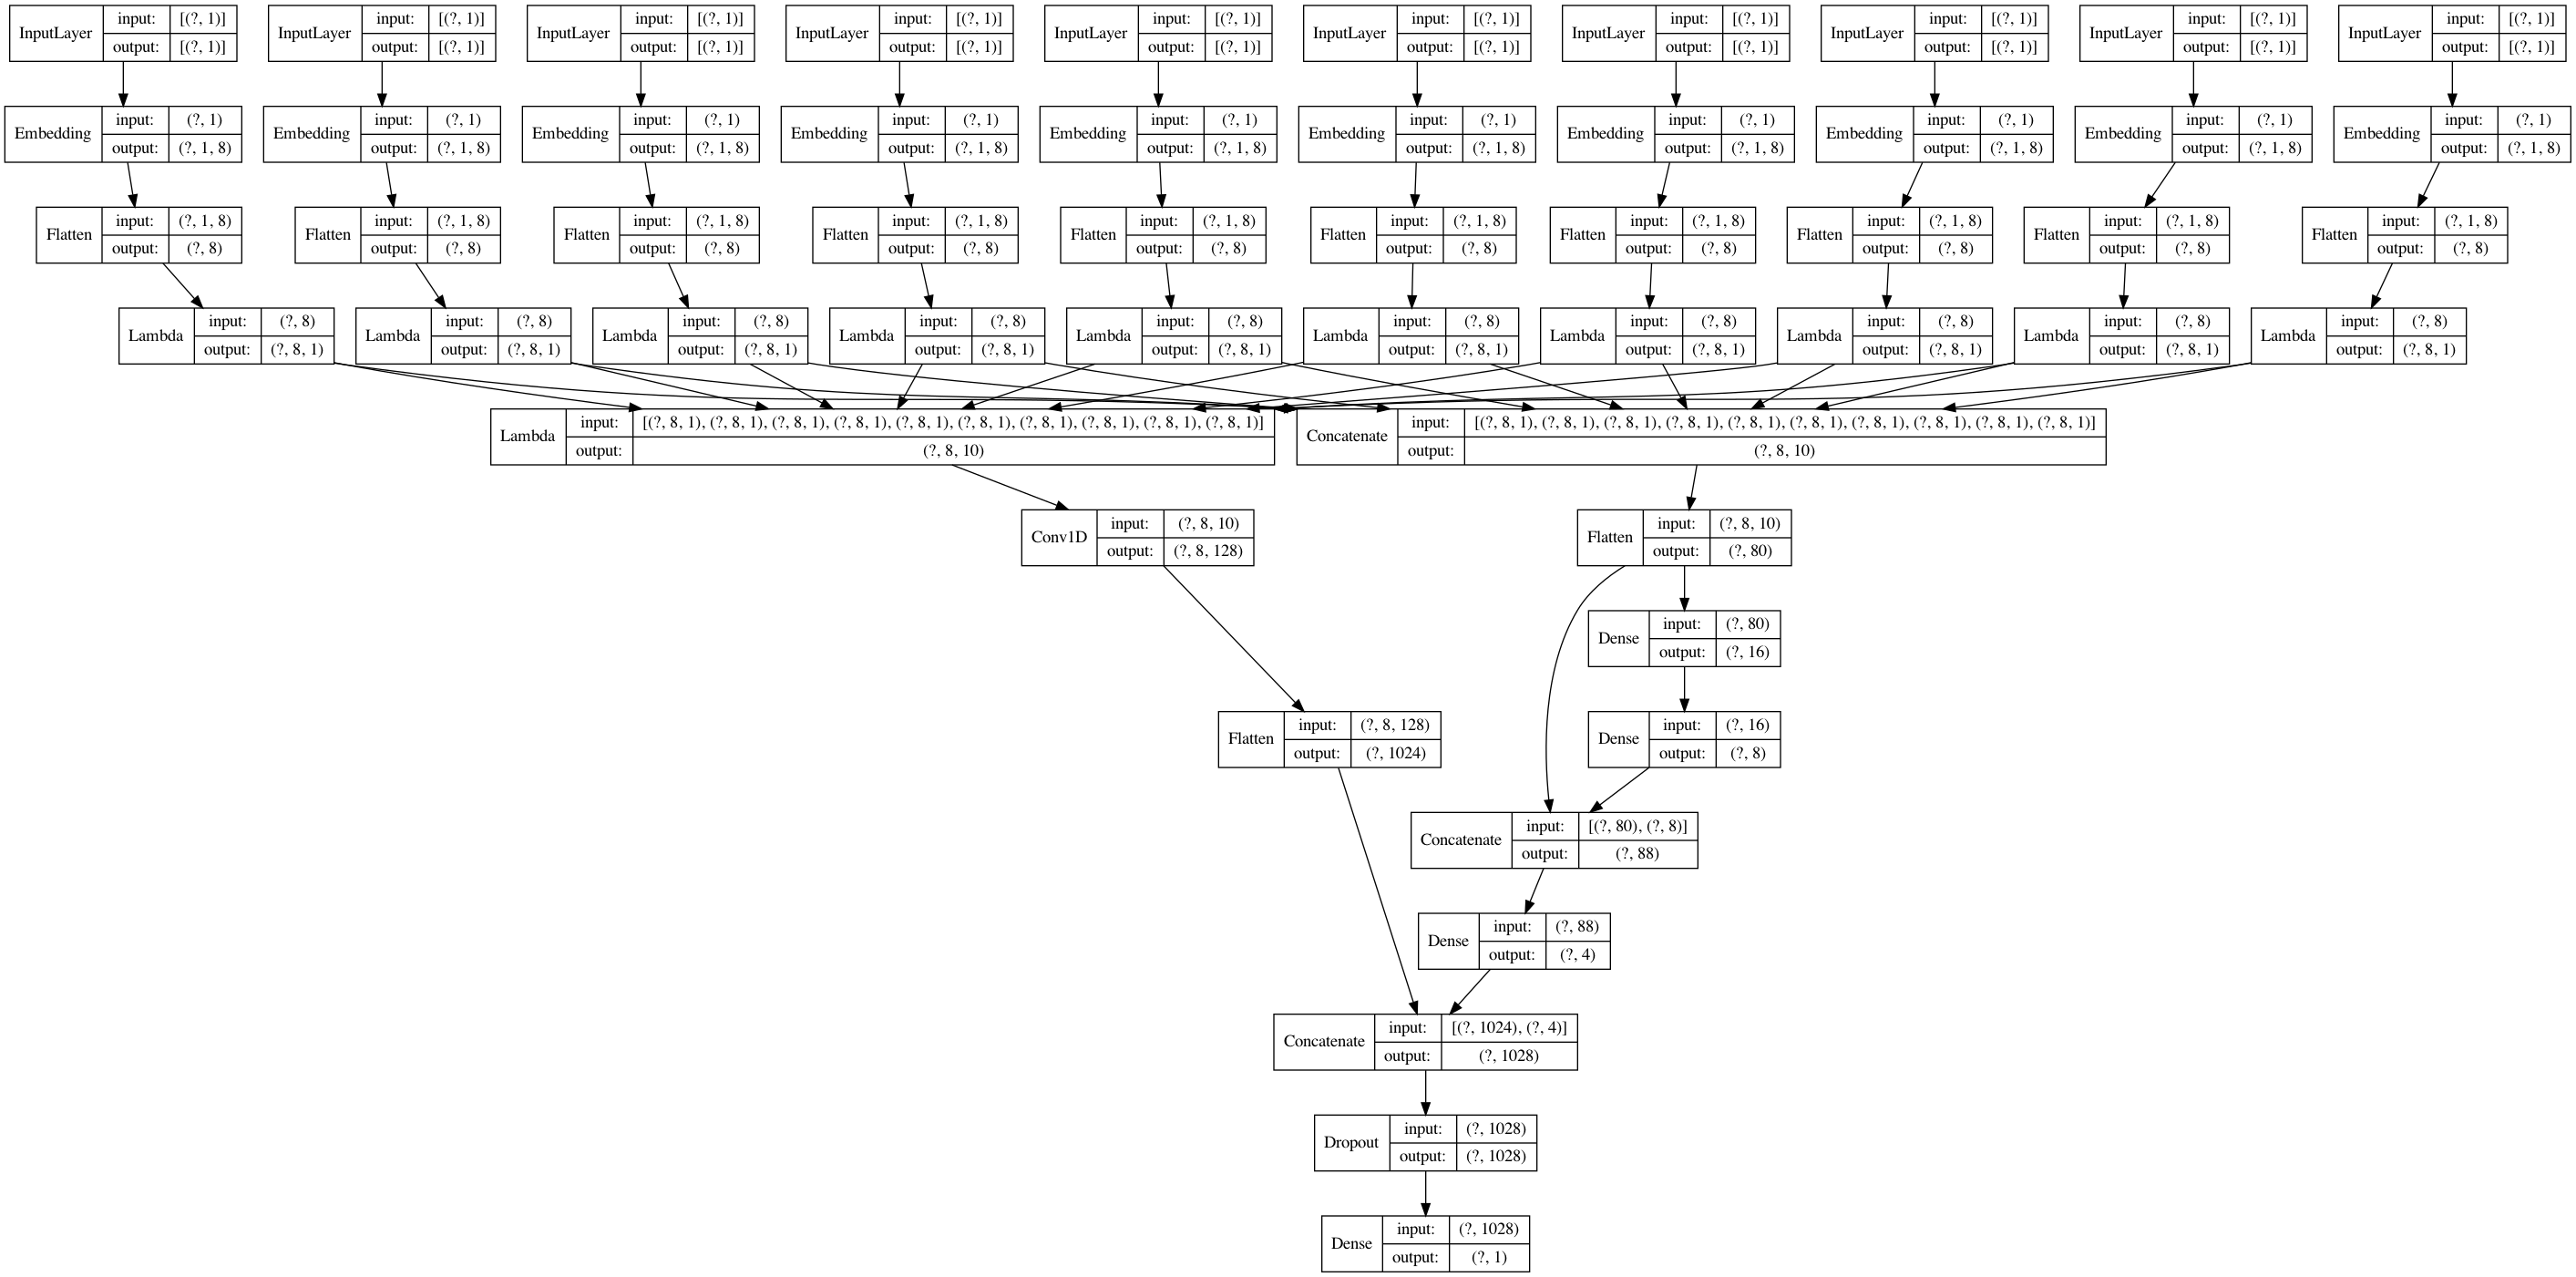

In [15]:
# Concatenate MF and MLP parts
predict_vector = Concatenate()([MF_part, mlp_concat])
predict_vector = Dropout(0.2)(predict_vector)

# Final prediction layer
prediction = Dense(1, name = "prediction")(predict_vector) # activation='sigmoid',
model = Model([users_mean_rating, 
                             user_reviewcount, locationId, 
                             createdDate, photonum, fch, category_l, rated_count,
                                  average_photonum, average_rating], prediction)
model.compile(loss="mse", optimizer=RMSprop(lr=1e-4), metrics=[tf.keras.metrics.AUC()])

Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

In [25]:
history = model.fit(x=[encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                       encoded_fch, encoded_category_l, encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating],
                        y=global_df['rating'], batch_size=2048, epochs=20, validation_split=0.005, verbose=1)

plt.plot(history.history["loss"], label="train loss")  
plt.plot(history.history["val_loss"], label="validation loss") 
plt.legend() 
plt.title("Loss") 
plt.show()  

Epoch 1/20


InvalidArgumentError:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model/prediction/BiasAdd:0) = ] [[-0.00658111926][-0.00857383944][-0.015101702]...] [y (Cast_4/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_1/Assert}}]] [Op:__inference_train_function_3703]

Function call stack:
train_function


# item 유사도 반환

In [19]:
# 모델 불러오기 
from keras.models import model_from_json 
json_file = open(os.path.join("..","realtime_model","wnd_global_model_0706.json"), "r") 
loaded_model_json = json_file.read() 
json_file.close() 

loaded_model = model_from_json(loaded_model_json, custom_objects={'tf': tf, 'n_factors':8})

loaded_model.load_weights(os.path.join("..","realtime_model","wnd_global_model_0706.h5"))
print("Loaded model from disk")

Loaded model from disk


In [20]:
def latent_to_vec(feature, model, location_df, h_size, input_features):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    test = input_features
                             
    locationId_latent_vector = intermediate_layer_model.predict(test)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']
    
    # 아이템별 의미 벡터 생성 
    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId')
    return vec

In [22]:
vec = latent_to_vec('FM_locationId', loaded_model, global_df, 8, [encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                             encoded_fch, encoded_category_l, encoded_rated_count,
                             encoded_average_photonum, encoded_average_rating])

AssertionError: in user code:

    /Users/baeyuna/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    /Users/baeyuna/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/baeyuna/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/baeyuna/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/baeyuna/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1122 predict_step  **
        return self(x, training=False)
    /Users/baeyuna/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /Users/baeyuna/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /Users/baeyuna/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/network.py:899 _run_internal_graph
        assert str(id(x)) in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("FM_locationId_1/Identity:0", shape=(None, 1, 8), dtype=float32)


In [28]:
# vec.to_csv(os.path.join("..","realtime_model",'wnd_global_vec2.csv'))#, index=False)

vecs = pd.read_csv(os.path.join("..","realtime_model",'wnd_global_vec_0706.csv')) 
vecs.index = vecs['locationId']
vecs = vecs.drop(columns = ['locationId'], axis=1) 
vec = vecs.copy()
vec

,0,1,2,3,4,5,6,7
locationId,,,,,,,,
1500428988,-0.099430,-0.099430,-0.099430,-0.099430,-0.099430,-0.099047,-0.099047,-0.099047
1475741466,0.060001,0.060001,0.060001,0.059965,0.059965,0.059884,0.059884,0.059884
33880173,0.076219,0.076219,0.076219,0.076219,0.076219,0.076219,0.076219,0.076219
1517144962,0.076219,0.076219,0.076219,0.076219,0.076219,0.076219,0.076219,0.076219
1569821908,0.076219,0.076219,0.076219,0.076219,0.076219,0.076219,0.076219,0.076219
...,...,...,...,...,...,...,...,...
7033805,0.007709,0.007709,0.007709,0.007709,0.007709,0.007709,0.007709,0.007709
6643598,0.027531,0.027531,0.027531,0.027531,0.027531,0.027531,0.027531,0.027531
8769938,0.027531,0.027531,0.027531,0.027531,0.027531,0.027531,0.027531,0.027531


In [29]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
import random

def cosim_id(df, vec, item_id):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy() 
    sim = []
    
    # 인풋 호텔 정보 데이터에 없는 경우 종료 
    if item_id not in vec.index.tolist():
        return 
        
    for i in range(len(vec)):
        sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))

    new_vec['sim'] = sim
    # sim 높은 순 
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    sim_sorted = new_vec['locationId'].tolist()
    # 인풋 호텔정보 빼고 유사도 높은 순대로 id 
    if item_id in sim_sorted:
        sim_sorted.remove(item_id) 
    return sim_sorted 


def sim_item(vec, df, item_id, top):
    top_id = cosim_id(df, vec, item_id)
    
    if type(top_id) == list :
        df = df.drop_duplicates(['locationId'], keep='last')
        recommend_rst = [] 
        for x in top_id:
            if df.loc[df['locationId']==x].category.values[0]== 'EAT':
                recommend_rst.append([df.loc[df['locationId']==x][['place.name', 'land.addr']]])

        print('input hotel:', df.loc[df['locationId']==item_id]['place.name'].unique()[0])
        print('-'*10) 
        for i in range(len(recommend_rst[:top])):
            print('top', i+1, recommend_rst[i][0]['place.name'].values[0])
            print('  주소', recommend_rst[i][0]['land.addr'].values[0]) 
        
    else:
        answer_lst = ['해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.', '해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.']
        x = random.randint(0, len(answer_lst)-1) 
        return answer_lst[x] 

# 여러개 인풋 유사도 함수

In [57]:
from random import sample

def sim_n_item(vec, df, item_id, top):
    recom_df = pd.DataFrame(columns=['place.name', 'land.addr'])
    for i in item_id:
        top_id = cosim_id(df, vec, i)

        if type(top_id) == list :
            df = df.drop_duplicates(['locationId'], keep='last')
            recommend_rst = pd.DataFrame(columns=['place.name', 'land.addr'])
            for x in top_id:
                if df.loc[df['locationId']==x].category.values[0]== 'EAT':
                    new_data = [df.loc[df['locationId']==x]['place.name'].values[0], df.loc[df['locationId']==x]['land.addr'].values[0]]
                    recommend_rst.loc[len(recommend_rst)] = new_data
            recommend_rst = recommend_rst.iloc[:10,:] # 각 아이템별 top10 
            recom_df = pd.concat([recom_df, recommend_rst])   

        else:
            answer_lst = ['해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.', '해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.']
            x = random.randint(0, len(answer_lst)-1) 
            return answer_lst[x] 

    recom_df = recom_df.reset_index()
    recom_df = recom_df.drop(columns='index', axis=1)
    recom_df = recom_df.drop_duplicates(['place.name'], keep='last')

    # create random index
    rindex =  np.array(sample(range(len(recom_df)), 10))
    # get 10 random rows from df
    recom_df = recom_df.iloc[rindex,:]
    recom_df = recom_df.reset_index()
    recom_df = recom_df.drop(columns='index', axis=1)

    print('inputs:') 
    for i in item_id:
        print(df.loc[df['locationId']==i]['place.name'].unique()[0])
    
    print('-'*10) 
    for i in range(len(recom_df)):
        print('top', i+1, recom_df.loc[i,'place.name'])
        print('  주소', recom_df.loc[i,'land.addr']) 

In [58]:
# 여러개 인풋 
recom_df = sim_n_item(vec, global_df, [18057919, 38692429], 10) 
recom_df

inputs:
토요코인호텔서울동대문
페어링룸
----------
top 1 민소한우
  주소 서울특별시 영등포구 여의도동 26 S-TRENUE
top 2 Myeongdong Gyoja Cheongdaemun
  주소 error
top 3 남매집
  주소 서울특별시 중구 북창동 19-1
top 4 민스키친
  주소 서울특별시 강남구 신사동 651-4
top 5 서울 베이킹 컴퍼니 - JW 메리어트 동대문 스퀘어 서울
  주소 서울특별시 종로구 종로6가 289-3
top 6 왓어샐러드
  주소 서울특별시 용산구 이태원동 74-33
top 7 이춘복참치
  주소 서울특별시 용산구 남영동 85-1
top 8 일일향
  주소 서울특별시 강남구 신사동 601-3
top 9 버거뱅
  주소 error
top 10 목란
  주소 서울특별시 종로구 평동 26-10


In [59]:
# 여러개 인풋  
sim_n_item(vec, global_df, [18057919, 8769938, 9047505], 10) 

inputs:
토요코인호텔서울동대문
C27
만선호프
----------
top 1 서교가든
  주소 서울특별시 마포구 서교동 466-1
top 2 조박집
  주소 서울특별시 마포구 용강동 40-1
top 3 트렌치타운
  주소 서울특별시 용산구 이태원동 99-14 모뎀빌
top 4 바81
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 5 버드나무집 역삼점
  주소 서울특별시 강남구 역삼동 689-12
top 6 왓어샐러드
  주소 서울특별시 용산구 이태원동 74-33
top 7 커피별 녹색잔
  주소 서울특별시 종로구 소격동 115-2
top 8 Myeongdong Gyoja Cheongdaemun
  주소 error
top 9 맥심플랜트
  주소 서울특별시 용산구 한남동 683-140
top 10 민소한우
  주소 서울특별시 영등포구 여의도동 26 S-TRENUE


In [60]:
sim_n_item(vec, global_df, [18057919, 9047505], 10) 

inputs:
토요코인호텔서울동대문
만선호프
----------
top 1 만선호프
  주소 서울특별시 중구 을지로3가 95-2
top 2 남매집
  주소 서울특별시 중구 북창동 19-1
top 3 조박집
  주소 서울특별시 마포구 용강동 40-1
top 4 이춘복참치
  주소 서울특별시 용산구 남영동 85-1
top 5 커피별 녹색잔
  주소 서울특별시 종로구 소격동 115-2
top 6 툇마루밥상
  주소 서울특별시 송파구 문정동 46-11
top 7 돼지집
  주소 서울특별시 중구 태평로2가 69-7 대영빌딩
top 8 민소한우
  주소 서울특별시 영등포구 여의도동 26 S-TRENUE
top 9 일일향
  주소 서울특별시 강남구 신사동 601-3
top 10 버드나무집 역삼점
  주소 서울특별시 강남구 역삼동 689-12
